# Task 3
Please write a simple compiler – program, which translates one quantum circuit into another, using a restricted set of gates.

You need to consider just the basic gates for the input circuit, such as (I, H, X, Y, Z, RX, RY, RZ, CNOT, CZ).

The output circuit should consist only from the following gates: RX, RZ, CZ. In other words, each gate in the original circuit must be replaced by an equivalent combination of gates coming from the restricted set (RX, RZ, CZ) only.

For example, a Hadamard gate after compilation looks like this:

RZ(pi/2)
RX(pi/2)
RZ(pi/2)

Analyze what’s the overhead of the compiled program compared to the original one and propose how to improve it. What we mean by overhead is the following: by replacing all the initial gates with the restricted set of gates given in the problem, you will see that the resulting circuit is much more involved than the original one. This is what we called the overhead, and you may think about how to treat this problem, i.e. you could try to simplify as much as possible the resulting circuit.


## Solution

I will tackle the problem in a few stages. Firstly, I will try to prove that each of the input gates can be substituted with a circuit consisting of gates from the restricted set. To this end for each gate I should provide an equivalent circuit. This will allow me to determine lower and upper bounds of the overhead of the proposed translation. Then I will try to come up with some ideas or propositions on how to reduce the circuit.

Because of POC character of the task I will start with preparing basic mappings with simple gate classes. Below sample gate class implementation. The rest can be found in `gates.py`.

In [7]:
# Most important dependency, as some algebraic computations will be inevitable
import numpy as np

from gates import RXGate

# Gates accepts parameters in the following order angle, control, target.
# If param doesn't apply to the given gate it is ommited, e.g. RXGate accepts params theta and target only.

# Each gate can be dumped to string and provide coresponding matrix
rx_gate = RXGate(np.pi, 0)
mat = rx_gate.to_matrix()

print("Introduce yourself:")
print(rx_gate)
print("Matrix representation:")
print(mat)


Introduce yourself:
RX(3.141592653589793, 0)
Matrix representation:
[[6.123234e-17+0.j 0.000000e+00-1.j]
 [0.000000e+00-1.j 6.123234e-17+0.j]]


We need to achieve `I, H, X, Y, Z, RX, RY, RZ, CNOT, CZ` with `RX, RZ, CZ`, in other words, we need to prove that restricted set is universal for computation with initial set.

In [8]:
# We will collect all transpilation mappings in a dict
mappings = {}

### Batch #1 `I, RX, RZ, X, Z, CZ` (the trivial ones)

In [9]:
from gates import IGate, RXGate, RZGate, XGate, ZGate, CZGate

#### 1. I (Identity gate)
Keeping in mind simplicity it's best to omit it.

In [10]:
def transpile_I(_gate):
    return []

mappings[IGate] = transpile_I

#### 2. RX, RZ, CZ
These three gates doesn't need to be transpiled. We can map them with an identity manner.

In [11]:
def transpile_identity(gate):
    return [gate]

mappings[RXGate] = transpile_identity
mappings[RZGate] = transpile_identity
mappings[CZGate] = transpile_identity

In [12]:
# Quick check
gate = RXGate(np.pi/2, 0)
[mapped] = mappings[gate.__class__](gate)
print(mapped)

RX(1.5707963267948966, 0)


#### 3. X, Z
These are specific cases of rotations RX and RZ. For each it's enough to use one gate. 

$ X = RX(\pi), \\ Z = RZ(\pi)$


In [13]:
def rotate_by_pi(rotation_gate):
    def mapping(gate):
        return [rotation_gate(np.pi, gate.target)]
        
    return mapping

mappings[XGate] = rotate_by_pi(RXGate)
mappings[ZGate] = rotate_by_pi(RZGate)

In [14]:
# Quick check
gate = ZGate(0)
[mapped] = mappings[gate.__class__](gate)
print(mapped)

RZ(3.141592653589793, 0)


### Batch #2 `RY, Y,  H, CNOT`

In [15]:
from gates import RYGate, YGate, HGate, CNOTGate

#### 4. RY
This is first gate which requires some effort. Fortunatelly, referring to classical rotation matrices theory (in particular Euler's rotation theorem), any 3d rotation may be decomposed into 3 rotations from some bases, including `ZXZ`. According to this, we may expect to be able to decompose `RY` the following way. \
$ RZ(\alpha) RX(\beta) RZ(\gamma) = RY(\delta)$ \
In matrix form: \
$
\begin{bmatrix} e^{-i\frac{\alpha}{2}} & 0 \\ 0 & e^{i\frac{\alpha}{2}} \end{bmatrix}
\begin{bmatrix} cos(\frac{\beta}{2}) & -isin(\frac{\beta}{2}) \\ -isin(\frac{\beta}{2}) & cos(\frac{\beta}{2}) \end{bmatrix}
\begin{bmatrix} e^{-i\frac{\gamma}{2}} & 0 \\ 0 & e^{i\frac{\gamma}{2}} \end{bmatrix}
=
\begin{bmatrix} cos(\frac{\delta}{2}) & -sin(\frac{\delta}{2}) \\ sin(\frac{\delta}{2}) & cos(\frac{\delta}{2}) \end{bmatrix}
$ \
Because `RX` and `RY` differs only by sine coefficients, it seems reasonable to check wheter is it possible to achive them using Z rotations and keep the same angle in `RX` and `RY`. \
Values $\alpha = \frac{1}{2}\pi$ and $\gamma = \frac{3}{2}\pi$ satisfy this requirement. (I've decided to extract computational part to `appendix.pdf` to keep this notebook readable, feel free to check it in the same repository)\
$RY(\theta) = RZ(\frac{1}{2}\pi)RX(\theta)RZ(\frac{3}{2}\pi)$

In [17]:
def transpile_RY(gate):
    return [
        RZGate(np.pi/2, gate.target),
        RXGate(gate.theta, gate.target),
        RZGate(3/2*np.pi, gate.target)
    ]

mappings[RYGate] = transpile_RY

#### 5. Y
Given above, we need to simply deliberate the fact that $Y = RY(\pi)$, so:\
$Y = RY(\pi) = RZ(\frac{1}{2}\pi)RX(\pi)RZ(\frac{3}{2}\pi)$

In [19]:
def transpile_Y(gate):
    return [
        RZGate(np.pi/2, gate.target),
        RXGate(np.pi, gate.target),
        RZGate(3/2*np.pi, gate.target)
    ]

mappings[YGate] = transpile_Y

#### 6. H
One of well-known `H` decompositions is $H = RY(\frac{1}{2}\pi)Z$. Once again we can use `RY` decomposition and obtain:\
$H = RZ(\frac{1}{2}\pi)RX(\frac{1}{2}\pi)RZ(\frac{3}{2}\pi)Z = RZ(\frac{1}{2}\pi)RX(\frac{1}{2}\pi)RZ(\frac{5}{2}\pi)$

In [20]:
def transpile_H(gate):
    return [
        RZGate(np.pi/2, gate.target),
        RXGate(np.pi/2, gate.target),
        RZGate(5/2*np.pi, gate.target)
    ]

mappings[HGate] = transpile_H

#### 7. CNOT
Looking at available gates it's obvious that we have to use `CZ` gate. It's benefeitial to verbalize `Z`'s behaviour - it changes phase of $|1 \rangle$. Then it's easy to observe, that we can simply change second qubit's (if the first one is control) basis with `H` gates.
$
H Z H = \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}
\begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix}
\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}
=
\begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix}
= X
$\
Then:\
$(I \otimes H)CZ(I \otimes H) = CNOT$

In [21]:
def transpile_CNOT(gate):
    left_h, right_h  = HGate(gate.target), HGate(gate.target)
    return transpile_H(left_h) + [CZGate(gate.control, gate.target)] + transpile_H(right_h)

mappings[CNOTGate] = transpile_CNOT

### Transpiler
That's all! At least, when it comes to having any transpilation.
Let's assume that our circuit definition interface will be simple list of gates appearing in the same order as in circuit.

In [55]:
from functools import reduce

class SimpleTranspiler:
    @staticmethod
    def transpile_gate(gate):
        return mappings[gate.__class__].__call__(gate)
    
    @staticmethod
    def transpile_circuit(circ):
        """Transpile circuit given as list of gates
        Args:
            circ: list[Gate]
        Returns:
            transpiled_circ: list[Gate]
        """
        transpiled = map(SimpleTranspiler.transpile_gate, circ)
        flatten_transpiled = reduce(list.__add__, transpiled)
        return flatten_transpiled

### Visualization & Running
According to the KISS and YAGNI rules (as it saves time and unnecessary code loosely related to the problem) I've decided to reach for a `qiskit` (well known and popular lib) and use it as a tool for building, visualization and running circuits. (and don't use it's other features).

In [64]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import *
from qiskit.visualization import *

qiskit_gates_applyers = {
    IGate: lambda circ, gate: circ.i(gate.target),
    RXGate: lambda circ, gate: circ.rx(gate.theta, gate.target),
    RZGate: lambda circ, gate: circ.rz(gate.theta, gate.target),
    XGate: lambda circ, gate: circ.x(gate.target),
    ZGate: lambda circ, gate: circ.z(gate.target),
    CZGate: lambda circ, gate: circ.cz(gate.control, gate.target),
    RYGate: lambda circ, gate: circ.ry(gate.theta, gate.target),
    YGate: lambda circ, gate: circ.y(gate.target),
    HGate: lambda circ, gate: circ.h(gate.target),
    CNOTGate: lambda circ, gate: circ.cx(gate.control, gate.target)
}        

def build_in_qiskit(circ, qbits):
    """Build qiskit circuit from provided list definition
        Args:
            circ: list[Gate]
            qbits: int (number of qbits in builded circuit)
        Returns:
            qiskit_circ: QuantumCircuit
    """
    qiskit_circ = QuantumCircuit(qbits)
    for gate in circ:
        qiskit_gates_applyers[gate.__class__].__call__(qiskit_circ, gate)
    return qiskit_circ

Sample circuit returning one of the Bell states $\frac{1}{\sqrt{2}}(|01\rangle + |10\rangle)$ (requested to obtain in task 2)

In [56]:
circ = [
    XGate(0),
    XGate(1),
    HGate(0),
    CNOTGate(0,1)
]

qiskit circuit:

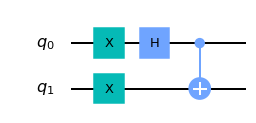

In [62]:
qiskit_circ = build_in_qiskit(circ, 2)
qiskit_circ.draw(output='mpl')

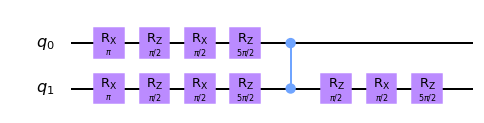

In [63]:
transpiled = SimpleTranspiler.transpile_circuit(circ)
qiskit_transpiled = build_in_qiskit(transpiled, 2)
qiskit_transpiled.draw(output='mpl')

Now we can compare statevectors and probabilities of constructed circuits (initial vs. transpiled)

In [77]:
# Non-transpiled circuit
print("Statevctor:")
print(Statevector.from_instruction(qiskit_circ).to_dict(decimals=6))
print("Probabilities:")
print(Statevector.from_instruction(qiskit_circ).probabilities_dict(decimals=6))

Statevctor:
{'01': (-0.7071067811865475+0j), '10': (0.7071067811865475+0j)}
Probabilities:
{'01': 0.5, '10': 0.5}


In [78]:
# Transpiled circuit
print("Statevctor:")
print(Statevector.from_instruction(qiskit_transpiled).to_dict(decimals=6))
print("Probabilities:")
print(Statevector.from_instruction(qiskit_transpiled).probabilities_dict(decimals=6))

Statevctor:
{'01': (-1.1102230246251565e-16-0.7071067811865477j), '10': (1.1102230246251565e-16+0.7071067811865475j)}
Probabilities:
{'01': 0.5, '10': 0.5}


### First conclusions
Although circuits differ by statevectors, yielded probabilities are correct. Statevectors differ by global phase of $-i$. 

Moreover, statevector of transpiled circuit seem to include small error in real part, which is caused by numerical precision. This is expected, as by introducing greater number of gates we increase number of operations performed on floating point variables.

Number of the gates number changes arised from the transpilation process varies from $-1$ (in case of `I`) up to 7 (in case of `CNOT`). As it is dependent on the input circuit structure, we can define upper bound of new circuit size basing on pesimistic case scenario (exclusively `CNOT`s).

Upper bound of transpiled circuit gates number is $7n$ (if $n$ is the initial number of gates)

### Reduction idea
Very natural idea is to cumulate long chains of single-qubit gates into one unitary matrix and then decompose it into 3 rotations (just like we did it in case of `RY`). Then pesimistic case of `CNOT`s of $7n$ may decrease to $n + 6 + (n-1)*3 = 4n + 3$.

Once again we could solve matrix equation:

$
\begin{bmatrix} 
e^{-i\frac{\alpha+\gamma}{2}} cos(\frac{\beta}{2}) &
-i e^{-i\frac{\alpha-\gamma}{2}} sin(\frac{\beta}{2}) \\
-ie^{i\frac{\alpha-\gamma}{2}} sin(\frac{\beta}{2}) &
e^{i\frac{\alpha+\gamma}{2}} cos(\frac{\beta}{2}) \end{bmatrix}
=
\begin{bmatrix} u_{11} & u_{12} \\ u_{21} & u_{22} \end{bmatrix}
$

For the sake of brevity I will use `OneQubitEulerDecomposer` class (https://qiskit.org/documentation/stubs/qiskit.quantum_info.OneQubitEulerDecomposer.html) from `qiskit` which finds angles based on similar equations.

In [99]:
QISKIT_DECOMPOSER = OneQubitEulerDecomposer(basis='ZXZ')
_transpiled_cnot =  SimpleTranspiler.transpile_gate(CNOTGate(0, 1))

class SimpleTranspilerV2:
    @staticmethod
    def transpile_unitary(gate, line):
        theta, phi, lam = QISKIT_DECOMPOSER.angles(gate)
        return [RZGate(theta, line), RXGate(phi, line), RZGate(lam, line)]
    
    @staticmethod
    def transpile_circuit(circ):
        """Transpile circuit given as list of gates
        Args:
            circ: list[Gate]
        Returns:
            transpiled_circ: list[Gate]
        """
        lines = {}
        transpiled = []
        
        for gate in circ:
            if gate.__class__ in (CNOTGate, CZGate):
                # If it is 2-qubit gate first apply transpiled gates on target line
                # Then "flush" both target and control
                # And again apply transpiled gates on target line
                if gate.__class__ == CNOTGate:
                    for tg in _transpiled_cnot[:3]:
                        SimpleTranspilerV2._add_to_line(lines, gate.target, tg)
                
                if gate.control in lines.keys():
                    transpiled += SimpleTranspilerV2.transpile_unitary(lines[gate.control], gate.control)
                    del lines[gate.control]
                    
                if gate.target in lines.keys():
                    transpiled += SimpleTranspilerV2.transpile_unitary(lines[gate.target], gate.target)
                    del lines[gate.target]
                
                transpiled.append(CZGate(gate.control, gate.target))
                    
                if gate.__class__ == CNOTGate:
                    for tg in _transpiled_cnot[4:]:
                        SimpleTranspilerV2._add_to_line(lines, gate.target, tg)
            else:
                # If it is 1-qubit gate apply gate on target line
                SimpleTranspilerV2._add_to_line(lines, gate.target, gate)
        
        # Flush all lines with not decomposed rotations
        for line in lines.keys():
            transpiled += SimpleTranspilerV2.transpile_unitary(lines[line], line)
            
            
        return transpiled
    
    @staticmethod
    def _add_to_line(lines, line, gate):
        if line in lines.keys():
            lines[line] = lines[line] @ gate.to_matrix()
        else:
            lines[line] = gate.to_matrix()
            

Simple circuit from "pesimistic" class

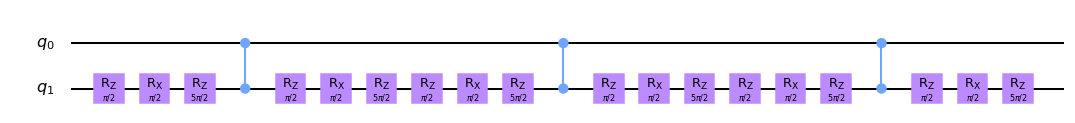

In [84]:
pesimistic_circ = [
    CNOTGate(0, 1),
    CNOTGate(0, 1),
    CNOTGate(0, 1),
]

transpiled = SimpleTranspiler.transpile_circuit(pesimistic_circ)
qiskit_transpiled = build_in_qiskit(transpiled, 2)
qiskit_transpiled.draw(output='mpl')

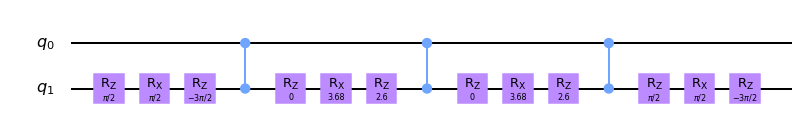

In [100]:
transpiled_v2 = SimpleTranspilerV2.transpile_circuit(pesimistic_circ)
qiskit_transpiled_v2 = build_in_qiskit(transpiled_v2, 2)
qiskit_transpiled_v2.draw(output='mpl')

In [101]:
print(Statevector.from_instruction(qiskit_transpiled).probabilities_dict(decimals=6))
print(Statevector.from_instruction(qiskit_transpiled_v2).probabilities_dict(decimals=6))

{'00': 1.0}
{'00': 0.981139, '10': 0.018861}


Unfortunatelly once again, because of floating point arithmetic, we can observe loss in circuit result correctness alined with gates "compression".

In [104]:
import random

ALL_GATES = [IGate, RXGate, RZGate, XGate, ZGate, CZGate, RYGate, YGate, HGate, CNOTGate]


class Experiment:
    def random_circ(self, qubits_n, gates_n):
        qbits = range(qubits_n)
        gates = []
        for _i in range(gates_n):
            [gate_class] = random.sample(ALL_GATES, 1)
            if gate_class in (CZGate, CNOTGate):
                [target, control] = random.sample(qbits, 2)
                gates.append(gate_class(control, target))
            elif gate_class in (RXGate, RZGate, RYGate):
                [target] = random.sample(qbits, 1)
                theta = random.random() * 2 * np.pi
                gates.append(gate_class(theta, target))
            else:
                [target] = random.sample(qbits, 1)
                gates.append(gate_class(target))
        return gates

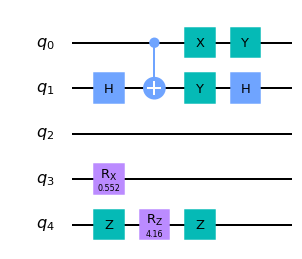

In [109]:
c = Experiment().random_circ(5, 10)
q = build_in_qiskit(c, 5)
q.draw(output='mpl')

### Further ideas

Because `CNOT` and `CZ` may introduce entanglement we can't treat rotation of each qubit separately. Using tensor product we can construct multi-qubits gates (just like we did while derivating `CNOT`). During further research i would represent cirucit as a large gate and try to decompose it with _Cosine-Sine-Decomposition_ method (which is recursion leading to many equations similar to the one from `RY` derivation), as in the following paper https://arxiv.org/abs/1208.0194.

The main caveats of proposed approach are errors introduced by floating point arithmetic and detachment from the real gates implementations. Instead of compiling chains of gates into 3 rotations, it could be benefitial to replace them with universal gates `U3` (implemented this way: $U3(\theta, \phi, \lambda) = RZ(\phi) RX(-\pi/2) RZ(\theta) RX(\pi/2)RZ(\lambda)$) which rotate by arbitrary angles only around Z axis.

$\begin{cases}
e^{-i\frac{\alpha+\gamma}{2}} cos(\frac{\beta}{2}) &=  a_{11} \\
-i e^{-i\frac{\alpha-\gamma}{2}} sin(\frac{\beta}{2}) &=  a_{12} \\
-ie^{i\frac{\alpha-\gamma}{2}} sin(\frac{\beta}{2}) &=  a_{21} \\
e^{i\frac{\alpha+\gamma}{2}} cos(\frac{\beta}{2}) &=  a_{22}
\end{cases}$

$\begin{array}
&e^{i(\alpha+\gamma)} = \frac{a_{22}}{a_{11}} \\
cos(\alpha+\gamma) + isin(\alpha+\gamma) = \frac{a_{22}}{a_{11}} \\
isin(\alpha+\gamma) = \frac{a_{22}}{a_{11}} - cos(\alpha+\gamma) \\
-sin^2(\alpha+\gamma) = (\frac{a_{22}}{a_{11}})^2 - 2 \frac{a_{22}}{a_{11}}cos(\alpha+\gamma) + cos^2(\alpha+\gamma)\\
2 \frac{a_{22}}{a_{11}}cos(\alpha+\gamma) = (\frac{a_{22}}{a_{11}})^2 + 1 \\
cos(\alpha+\gamma) = \frac{a_{22}}{2a_{11}} + \frac{a_{11}}{2a_{22}}\\
\alpha+\gamma = arcos(\frac{a_{22}^2 + a_{11}^2}{2a_{11}a_{22}})
\end{array}$

In [28]:
circ = [HGate(0), HGate(1)]

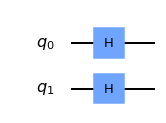

In [53]:
build_in_qiskit(circ, 2).draw(output='mpl')

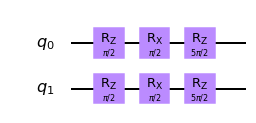

In [54]:
build_in_qiskit(Transpiler.transpile_circuit(circ), 2).draw(output='mpl')

In [50]:
Transpiler.transpile_circuit(circ)


$
\begin{bmatrix} e^{-i\frac{\alpha}{2}} & 0 \\ 0 & e^{i\frac{\alpha}{2}} \end{bmatrix}
\begin{bmatrix} cos(\frac{\beta}{2}) & -isin(\frac{\beta}{2}) \\ -isin(\frac{\beta}{2}) & cos(\frac{\beta}{2}) \end{bmatrix}
\begin{bmatrix} e^{-i\frac{\gamma}{2}} & 0 \\ 0 & e^{i\frac{\gamma}{2}} \end{bmatrix}
=
\begin{bmatrix} cos(\frac{\delta}{2}) & -sin(\frac{\delta}{2}) \\ sin(\frac{\delta}{2}) & cos(\frac{\delta}{2}) \end{bmatrix}
$

$
\begin{bmatrix} e^{-i\frac{\alpha}{2}} & 0 \\ 0 & e^{i\frac{\alpha}{2}} \end{bmatrix}
\begin{bmatrix} e^{-i\frac{\gamma}{2}} cos(\frac{\beta}{2}) & -i e^{i\frac{\gamma}{2}} sin(\frac{\beta}{2}) \\ -ie^{-i\frac{\gamma}{2}} sin(\frac{\beta}{2}) & e^{i\frac{\gamma}{2}} cos(\frac{\beta}{2}) \end{bmatrix}
=
\begin{bmatrix} cos(\frac{\delta}{2}) & -sin(\frac{\delta}{2}) \\ sin(\frac{\delta}{2}) & cos(\frac{\delta}{2}) \end{bmatrix}
$

$
\begin{bmatrix} 
e^{-i\frac{\alpha+\gamma}{2}} cos(\frac{\beta}{2}) &
-i e^{-i\frac{\alpha-\gamma}{2}} sin(\frac{\beta}{2}) \\
-ie^{i\frac{\alpha-\gamma}{2}} sin(\frac{\beta}{2}) &
e^{i\frac{\alpha+\gamma}{2}} cos(\frac{\beta}{2}) \end{bmatrix}
=
\begin{bmatrix} cos(\frac{\delta}{2}) & -sin(\frac{\delta}{2}) \\ sin(\frac{\delta}{2}) & cos(\frac{\delta}{2}) \end{bmatrix}
$

$\begin{cases}
e^{-i\frac{\alpha+\gamma}{2}} &= 1 \\
-i e^{-i\frac{\alpha-\gamma}{2}} &= -1 \\
-ie^{i\frac{\alpha-\gamma}{2}} &= 1 \\
e^{i\frac{\alpha+\gamma}{2}} &= 1
\end{cases}$

$\begin{cases}
e^{-i\frac{\alpha+\gamma}{2}} &= 1 \\
e^{-i\frac{\alpha-\gamma}{2}} &= -i \\
e^{i\frac{\alpha-\gamma}{2}} &= i \\
e^{i\frac{\alpha+\gamma}{2}} &= 1
\end{cases}$

$\begin{cases}
cos(\frac{\alpha+\gamma}{2}) - isin(\frac{\alpha+\gamma}{2}) &= 1 \\
cos(\frac{\alpha-\gamma}{2}) - isin(\frac{\alpha-\gamma}{2}) &= -i \\
cos(\frac{\alpha-\gamma}{2}) + isin(\frac{\alpha-\gamma}{2}) &= i \\
cos(\frac{\alpha+\gamma}{2}) + isin(\frac{\alpha+\gamma}{2}) &= 1
\end{cases}$

$\begin{array}
&cos(\frac{\alpha+\gamma}{2}) - isin(\frac{\alpha+\gamma}{2}) &= 1 \\
cos(\frac{\alpha+\gamma}{2}) - 1 &= isin(\frac{\alpha+\gamma}{2}) \\
cos^2(\frac{\alpha+\gamma}{2}) - 2cos(\frac{\alpha+\gamma}{2}) + 1 &= -1 \cdot sin^2(\frac{\alpha+\gamma}{2}) \\
cos^2(\frac{\alpha+\gamma}{2}) + sin^2(\frac{\alpha+\gamma}{2}) &= 2cos(\frac{\alpha+\gamma}{2}) - 1 \\
1 &= 2cos(\frac{\alpha+\gamma}{2}) - 1 \\
1 &= cos(\frac{\alpha+\gamma}{2}) \\
\frac{\alpha+\gamma}{2} = 2\pi + 2\pi n_1,  &n_1 \in \mathbb{Z}
\end{array}$

$\begin{array}
&cos(\frac{\alpha-\gamma}{2}) + isin(\frac{\alpha-\gamma}{2}) &= i \\
cos(\frac{\alpha-\gamma}{2}) &= i(1-sin(\frac{\alpha-\gamma}{2})) \\
cos^2(\frac{\alpha-\gamma}{2}) &= -1(1-2sin(\frac{\alpha-\gamma}{2})+sin^2(\frac{\alpha-\gamma}{2})) \\
cos^2(\frac{\alpha-\gamma}{2}) +sin^2(\frac{\alpha-\gamma}{2}) &= -1 + 2sin(\frac{\alpha-\gamma}{2}) \\
1 &= -1 + 2sin(\frac{\alpha-\gamma}{2}) \\
1 &= sin(\frac{\alpha-\gamma}{2}) \\
\frac{\alpha-\gamma}{2} = \frac{\pi}{2} + 2\pi n_2,  &n_2 \in \mathbb{Z}
\end{array}$

$\begin{cases}
\frac{\alpha+\gamma}{2} = 2\pi + 2\pi n_1,  &n_1 \in \mathbb{Z} \\
\frac{\alpha-\gamma}{2} = \frac{\pi}{2} + 2\pi n_2,  &n_2 \in \mathbb{Z} 
\end{cases}\\
\begin{cases}
\frac{\alpha+\gamma}{2}+ \frac{\alpha-\gamma}{2} &= \alpha &= 2\pi + \frac{\pi}{2} + 2\pi(n_1 + n_2)  ,  &n_1 \in \mathbb{Z}, n_2 \in \mathbb{Z}  \\
\frac{\alpha+\gamma}{2}- \frac{\alpha-\gamma}{2} &= \gamma &= 2\pi - \frac{\pi}{2} + 2\pi(n_1 - n_2),  &n_1 \in \mathbb{Z}, n_2 \in \mathbb{Z}  \\
\end{cases} \\
\begin{cases}
\alpha &= \frac{1}{2}\pi + 2\pi k_1,  &k_1 \in \mathbb{Z}  \\
\gamma &= \frac{3}{2}\pi + 2\pi k_2,  &k_2 \in \mathbb{Z}  \\
\end{cases} $

$
\alpha = \frac{5}{2}\pi, \gamma = \frac{3}{2}\pi \\
\begin{bmatrix} 
e^{-i\frac{\alpha+\gamma}{2}} cos(\frac{\beta}{2}) &
-i e^{-i\frac{\alpha-\gamma}{2}} sin(\frac{\beta}{2}) \\
-ie^{i\frac{\alpha-\gamma}{2}} sin(\frac{\beta}{2}) &
e^{i\frac{\alpha+\gamma}{2}} cos(\frac{\beta}{2}) \end{bmatrix}
=
\begin{bmatrix} cos(\frac{\beta}{2}) & -sin(\frac{\beta}{2}) \\ sin(\frac{\beta}{2}) & cos(\frac{\beta}{2}) \end{bmatrix}
=
\begin{bmatrix} cos(\frac{\delta}{2}) & -sin(\frac{\delta}{2}) \\ sin(\frac{\delta}{2}) & cos(\frac{\delta}{2}) \end{bmatrix}
$

In [4]:
import numpy as np

def RZ(a):
    return np.array([
        [np.exp(-1j *(a/2)), 0],
        [0, np.exp(1j *(a/2))]
    ])

def RX(a):
    return np.array([
        [np.cos(a/2), -1j * np.sin(a/2)],
        [-1j * np.sin(a/2), np.cos(a/2)]
    ])

In [28]:
RZ(np.pi/2) @ RX(np.pi/2) @ RZ(np.pi/2*5)

array([[-1.66533454e-16+0.70710678j,  5.55111512e-17+0.70710678j],
       [-5.55111512e-17+0.70710678j, -1.66533454e-16-0.70710678j]])

In [6]:
np.array([
    [1,1],
    [1,-1]
]) / np.sqrt(2)

array([[ 0.70710678,  0.70710678],
       [ 0.70710678, -0.70710678]])

In [22]:
from qiskit.circuit.library import RZGate, RXGate

In [23]:
RZGate(np.pi).to_matrix() @ RXGate(np.pi/2).to_matrix() @ RZGate(np.pi/2*5).to_matrix()

array([[ 0.5+0.5j,  0.5+0.5j],
       [-0.5+0.5j,  0.5-0.5j]])

In [24]:
RZGate(np.pi/2*5).to_matrix()

array([[-0.70710678+0.70710678j,  0.        +0.j        ],
       [ 0.        +0.j        , -0.70710678-0.70710678j]])

In [25]:
RZ(np.pi/2*5)

array([[-0.70710678+0.70710678j,  0.        +0.j        ],
       [ 0.        +0.j        , -0.70710678-0.70710678j]])

In [26]:
RXGate(np.pi/2).to_matrix()

array([[0.70710678+0.j        , 0.        -0.70710678j],
       [0.        -0.70710678j, 0.70710678+0.j        ]])

In [27]:
RX(np.pi/2)

array([[0.70710678+0.j        , 0.        -0.70710678j],
       [0.        -0.70710678j, 0.70710678+0.j        ]])

In [39]:
RZGate(np.pi/2).to_matrix()@ RXGate(np.pi/2).to_matrix()@ RZGate(np.pi/2).to_matrix()

array([[1.11022302e-16-0.70710678j, 0.00000000e+00-0.70710678j],
       [0.00000000e+00-0.70710678j, 1.11022302e-16+0.70710678j]])

In [36]:
RZ(np.pi/2)@ RX(np.pi/2) @ RZ(np.pi/2*5) 

array([[-1.66533454e-16+0.70710678j,  5.55111512e-17+0.70710678j],
       [-5.55111512e-17+0.70710678j, -1.66533454e-16-0.70710678j]])

In [38]:
RZ(np.pi/2) @ RX(np.pi/2) @ RZ(np.pi/2)

array([[ 0.70710678+1.11022302e-16j,  0.70710678+0.00000000e+00j],
       [ 0.70710678+0.00000000e+00j, -0.70710678+1.11022302e-16j]])

In [40]:
H

NameError: name 'H' is not defined

In [41]:
H = np.array([
    [1,1],
    [1,-1]
]) / np.sqrt(2)

In [43]:
Z = np.array([
    [1,0],
    [0,-1]
])

In [44]:
H @ Z @ H

array([[-2.23711432e-17,  1.00000000e+00],
       [ 1.00000000e+00, -2.23711432e-17]])

In [46]:
%matplotlib inline


from qiskit import QuantumCircuit, execute, Aer
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.quantum_info import *

In [52]:
import tmp

[[6.123234e-17+0.j 0.000000e+00-1.j]
 [0.000000e+00-1.j 6.123234e-17+0.j]]
